# Contagem de pessoas utilizando Codebook

Bruna Mayumi Kimura
-------------------------------------

In [1]:
%reset -f
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
from tqdm import tqdm

## Classe Codeword

In [2]:
class Codeword:

    def __init__(self, xt, aux):
        self.v = xt
        self.aux = aux


## Funções

In [3]:
# funções
def colordist(xt, vi):
    norma_xt = (xt[0]**2+xt[1]**2+xt[2]**2)
    norma_vi = (vi[0]**2+vi[1]**2+vi[2]**2)
    xv = (vi[0]*xt[0] + vi[1]*xt[1] + vi[2]*xt[2])

    if norma_vi <= 0:
        p = 0
    else:
        p = xv/norma_vi
    
    return math.sqrt(abs(norma_xt - p))

def brightness(xt, Imin, Imax):
    alpha = 0.4
    beta = 1.1
    Ilow = alpha * Imax
    Ihi = min(beta*Imax, (Imin/alpha))
    norma_xt = (xt[0]**2+xt[1]**2+xt[2]**2)**(1/2)
    if Ilow <= norma_xt and norma_xt <= Ihi:
        return True
    else:
        return False

## Geração do arquivo codebook

In [4]:
e1 = 12
N = 26

img = cv.imread('frames/teste.jpg')

C =[]
for row in range(img.shape[0]):
    C.append([])
    for col in range (img.shape[1]):
        C[row].append([])

# Algoritmo do Codebook
for t in tqdm(range(1, N+1)):
    n = 10 + t
    nome = 'bg_fixo/000000' + str(n)
    img = cv.imread(nome +'.jpg')
    img = img.astype(float)

    for row in range (img.shape[0]):
        for col in range(img.shape[1]):
            xt = img[row, col, :]
            R = xt[0]
            G = xt[1]
            B = xt[2]
            I =(R**2 + G**2 + B**2)**(1/2) 

            match = False

            for cw in C[row][col]:
                if (colordist(xt, cw.v) <= e1) and (brightness(xt, cw.aux[0], cw.aux[1])):
                    cw.v[0] = (cw.aux[2]*cw.v[0]+xt[0])/(cw.aux[2]+1)
                    cw.v[1] = (cw.aux[2]*cw.v[1]+xt[1])/(cw.aux[2]+1)
                    cw.v[2] = (cw.aux[2]*cw.v[2]+xt[2])/(cw.aux[2]+1)
                    Imin = min(I, cw.aux[0])
                    Imax = max(I, cw.aux[1])
                    cw.aux = [Imin, Imax, cw.aux[2]+1, max(cw.aux[3],t-cw.aux[5]), cw.aux[4], t]

                    match = True
                    break 

            if match == False:
                lista_aux = [I,I,1,t-1,t,t]
                C[row][col].append(Codeword(xt, lista_aux))

for row in range(img.shape[0]):
    for col in range(img.shape[1]):
        for codeword in C[row][col]:
            new_lamb = max(codeword.aux[3], (N-codeword.aux[5]+codeword.aux[4]-1))
            codeword.aux[3] = new_lamb

# saida = open("treino.p", "wb" )
# pickle.dump(C,  saida)
# saida.close()

100%|██████████| 26/26 [12:06<00:00, 51.00s/it]


## Função do filtro temporal

In [5]:
# esta função deveria retirar os codewords que são maiores que N/2, mas acaba retirando todos os valores

# new_C =[]
# for row in range(img.shape[0]):
#     new_C.append([])
#     for col in range (img.shape[1]):
#         new_C[row].append([])
        
# Tm = N/2

# for row in range(img.shape[0]):
#     for col in range(img.shape[1]):
#         for codeword in C[row][col]:
#             if codeword.aux[3]<=Tm:
#                 new_C.append(codeword)
                

## Detecção de pessoas (objetos estranho ao fundo)

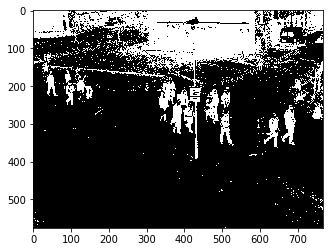

In [6]:
# entrada = open("treino.p", "rb" )
# C = pickle.load(entrada)
e2 = 5000

img_l = cv.imread('frames/frame_0142.jpg')


img_preta = np.zeros([img_l.shape[0],img_l.shape[1],3])


def fBGS(xt, cw):
    R = xt[0]
    G = xt[1]
    B = xt[2]
    I =(R**2 + G**2 + B**2)**(1/2) 


    for cw in C[row][col]:
        if (colordist(xt, cw.v) <= e2) and (brightness(xt, cw.aux[0], cw.aux[1])== True):
            #background
            cw.v[0] = (cw.aux[2]*cw.v[0]+xt[0])/(cw.aux[2]+1)
            cw.v[1] = (cw.aux[2]*cw.v[1]+xt[1])/(cw.aux[2]+1)
            cw.v[2] = (cw.aux[2]*cw.v[2]+xt[2])/(cw.aux[2]+1)
            Imin = min(I, cw.aux[0])
            Imax = max(I, cw.aux[1])
            #ainda não determinamos o valor de t
            t = 1
            cw.aux = [Imin, Imax, cw.aux[2]+1, max(cw.aux[3],t-cw.aux[5]), cw.aux[4], t]

            return True

        else:
        #foreground
            return False



for row in range (img_l.shape[0]):
    for col in range(img_l.shape[1]):
        pessoa = fBGS(img_l[row, col, :], C)
        if pessoa == False:
            for i in range(3):
                img_preta[row, col, i] = 255

plt.imshow(np.uint32(img_preta))
plt.show()
# entrada.close()

## Contagem de pessoas

In [7]:
imgray = cv.cvtColor(np.uint8(img_preta), cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 127, 255, 0)
im2, contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

pessoas = 0
for cnt in contours:
    area = cv.contourArea(cnt)
    if area > 100 and area < 400:
        pessoas += 1
        
print("Há {0} pessoas no frame".format(pessoas))

Há 20 pessoas no frame


## Tratamento de imagem (erosão e dilatação)

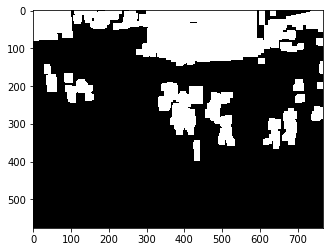

In [8]:
kernel = np.ones((6,6),np.uint8)
erosion = cv.erode(img_preta,kernel,iterations = 1)
dilation = cv.dilate(erosion,kernel,iterations = 3)

plt.imshow(np.uint32(dilation))
plt.show()

## Detector de blob

In [9]:
detector = cv.SimpleBlobDetector_create()

keypoints = detector.detect(np.uint8(dilation))

len(keypoints)
 

1